In [1]:

import torch
from time import time
from DocBuilder.utils import split_list_to_batch, restore_batched_list, unbind_sparse, top_k_sparse, tensor_retuen_type
from DocBuilder.Retriever_k_means import cluster_builder
import matplotlib.pyplot as plt
import numpy as np

/root/miniconda3/envs/RR/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4466


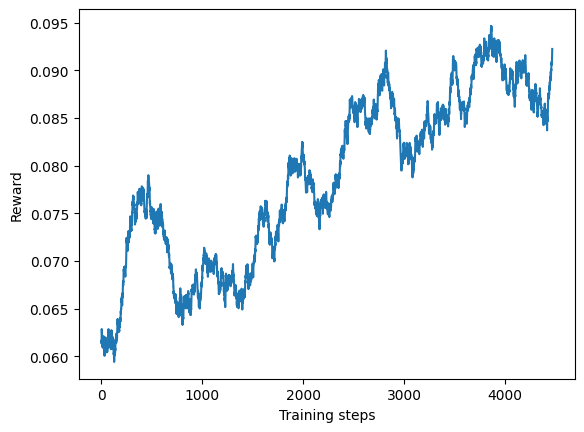

In [274]:

with open("reward_number_0.log", "r") as f:
    r = f.readlines()
r = [float(i) for i in r][:]
print(len(r))
moving_avg = []
ma = np.mean(r[:150])
ratio=1-10/len(r)
for x in r:
    ma = ratio * ma + (1-ratio) * x
    moving_avg.append(ma)

plt.ylabel("Reward")
plt.xlabel("Training steps")
plt.plot(moving_avg)
plt.show()

tensor(0.0065)


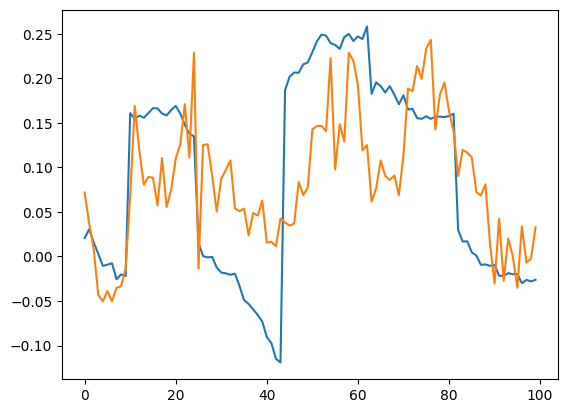

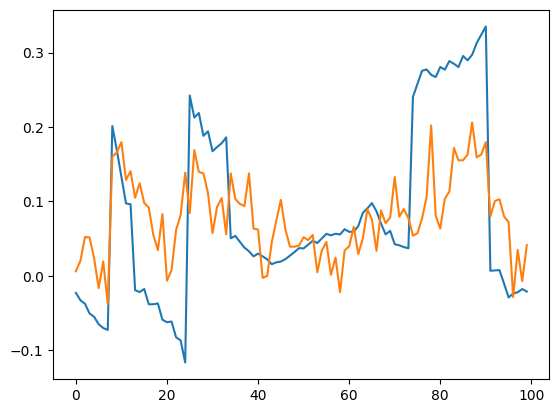

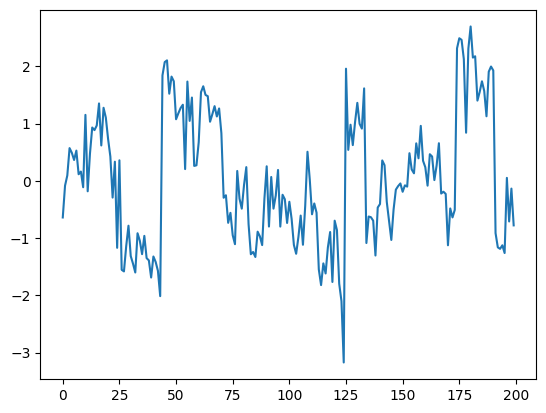

In [273]:
returns = torch.load("save/return.pt")
value = torch.load("save/value.pt")
print((returns - value).square().mean())
plt.plot(returns[:100])
plt.plot(value[:100])
plt.show()
plt.plot(returns[100:200])
plt.plot(value[100:200])
plt.show()
adv = returns - value
plt.plot(((adv-adv.mean())/adv.std())[:200])
plt.show()

In [30]:
from DatasetLoader import collate_func
q = "What dish, especially popular in parts of Wales and the English Midlands, is traditionally made from pig's heart, liver and fatty belly meat or bacon minced together, with herbs added for flavouring and sometimes bread crumbs"
a = "\n"
c = collate_func.collate()
o = c.collate_qa([[q,a]])
print(o[0].input_ids.shape)
for i in range(6):
    print(o[i])

s = "hello<knowledge>  </knowledge>"
s.replace(" </knowledge>", "d_t[j]+"+" </knowledge>")


torch.Size([1, 97])
{'input_ids': tensor([[    1,   518, 25580, 29962,  3532, 14816, 29903,  6778,    13, 29966,
         28385,  5485, 29958, 29871,  1533, 28385,  5485, 29958,  3529,  3867,
           263,  1407,  3273,  1234,  2729,   373,  7134,    13, 29966,   829,
         14816, 29903,  6778,    13,    13,  5618,   270,   728, 29892,  7148,
          5972,   297,  5633,   310, 13706,   322,   278,  4223, 13370,  5252,
         29892,   338, 11399,   635,  1754,   515,   282,   335, 29915, 29879,
          5192, 29892,   619,   369,   322,  9950,  1017,  1339,   368, 27654,
           470,  9922,   535,  1375,  1133,  4208, 29892,   411,   902,  5824,
          2715,   363, 21054,   473,   292,   322,  6041, 18423,  2181,  3774,
         29879,   518, 29914, 25580, 29962, 29871,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1,

'hello<knowledge> d_t[j]+ </knowledge>'

In [9]:
import torch
lossfunc = torch.nn.CrossEntropyLoss()
print(torch.vmap(lossfunc)(torch.randn([8,16,128]), torch.randint(0,128, size=[8,16])))
print(lossfunc(torch.randn([8,16,128]).view(-1,128), torch.randint(0,128, size=[8,16]).view(-1)))

tensor([5.1476, 5.1774, 4.9303, 5.7370, 5.0212, 5.0545, 5.3108, 5.7262])
tensor(5.3371)


In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from config import generate_config, token
from LM import llama_reader
import config
import torch
c = config.generate_config
c.do_sample = False
model = llama_reader.LLaMa_reader(config.LM_dir, "cuda", generate_config=c)

/root/miniconda3/envs/RR/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading checkpoint shards: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


In [2]:
from LM.Knowledge_encoder import KnowEncoder
import torch
model=KnowEncoder(4,4096,8)
model.to(torch.bfloat16)
print(model.model.training)
# prefix, prefix_masks = model.forward(['hello'], k = 1, dtype=torch.float16)
output = model.forward(['hello 1','hello 2','hello 3','hello 4','hello 5','hello 6'], 3)
print([output[i].shape for i in filter(lambda x: output[x] is not None, range(len(output)))])
    


True
encoder_heads output: torch.Size([6, 32, 4096])
[torch.Size([2, 96, 4096]), torch.Size([1, 8, 4096]), torch.Size([1, 8, 4096]), torch.Size([1, 8, 4096]), torch.Size([1, 8, 4096])]
